# Crop Recommendation Model Training

This notebook trains a Random Forest classifier for crop recommendation based on environmental and soil parameters.

**Features:**
- Nitrogen (N), Phosphorus (P), Potassium (K)
- Temperature, Humidity, pH, Rainfall

**Model:** RandomForestClassifier with MLflow tracking

## 1. Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import joblib
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import sys
import os

## 2. Setup MLflow Configuration

In [2]:
# Add project root to path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '../mlflow_tools'))
from mlflow_config import setup_mlflow, log_dataset_info

# Setup MLflow
setup_mlflow('crop_recommendation')

✅ MLflow configured successfully!
📊 Experiment: Crop-Recommendation-Model
🔗 Tracking URI: file:///home/abdallah/Abdallah/Projects/Intelligent-Crop-Irrigation-Advisor-clone/models/../mlruns
🆔 Experiment ID: 152495235150166473


/home/abdallah/Abdallah/Projects/Intelligent-Crop-Irrigation-Advisor-clone/.venv/lib/python3.13/site-packages/mlflow/tracking/_tracking_service/utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


'152495235150166473'

## 3. Load and Explore Dataset

In [3]:
# Load dataset
df = pd.read_csv("../../data/crop_data_with_soiltype.csv")
print(f"Data loaded successfully! Shape: {df.shape}")
print(f"\nAvailable crops: {df['label'].unique()}")
print(f"\nNumber of crops: {len(df['label'].unique())}")

# Display first few rows
df.head()

Data loaded successfully! Shape: (2200, 9)

Available crops: ['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']

Number of crops: 22


,N,P,K,temperature,humidity,ph,rainfall,label,soil_type
0,90.0,42.0,43.0,20.879744,82.002744,6.502985,202.935536,rice,clay
1,85.0,58.0,41.0,21.770462,80.319644,7.038096,226.655537,rice,clay
2,60.0,55.0,44.0,23.004459,82.320763,7.840207,263.964248,rice,clay
3,74.0,35.0,40.0,26.491096,80.158363,6.980401,242.864034,rice,clay
4,78.0,42.0,42.0,20.130175,81.604873,7.628473,262.717340,rice,clay


In [7]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   float64
 1   P            2200 non-null   float64
 2   K            2200 non-null   float64
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
 8   soil_type    2200 non-null   object 
dtypes: float64(7), object(2)
memory usage: 154.8+ KB


In [8]:
# Statistical summary
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


## 4. Prepare Data for Training

In [4]:
# Define features and target (including soil_type)
X = df[['N','P','K','temperature','humidity','ph','rainfall','soil_type']]
y = df['label']

# Encode soil_type as it's categorical
from sklearn.preprocessing import LabelEncoder
le_soil = LabelEncoder()
X['soil_type_encoded'] = le_soil.fit_transform(X['soil_type'])

# Use encoded version in features
X_features = X[['N','P','K','temperature','humidity','ph','rainfall','soil_type_encoded']]

print(f"Features: {list(X_features.columns)}")
print(f"Number of features: {len(X_features.columns)}")
print(f"Target variable: label")
print(f"Number of samples: {len(df)}")
print(f"\nSoil types found: {df['soil_type'].unique()}")
print(f"Soil type encoding: {dict(zip(le_soil.classes_, le_soil.transform(le_soil.classes_)))}")

Features: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'soil_type_encoded']
Number of features: 8
Target variable: label
Number of samples: 2200

Soil types found: ['clay' 'petmos' 'sandy']
Soil type encoding: {'clay': np.int64(0), 'petmos': np.int64(1), 'sandy': np.int64(2)}


In [5]:
# Split the data (using X_features which has encoded soil_type)
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 1760
Test set size: 440


## 5. Train Model with MLflow Tracking

In [7]:
# Start MLflow run
with mlflow.start_run(run_name="RandomForest_Crop_Recommendation_with_SoilType"):
    
    # Log parameters
    mlflow.log_param("model_type", "RandomForestClassifier")
    mlflow.log_param("n_estimators", 200)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("includes_soil_type", True)
    
    # Log dataset info
    log_dataset_info(df, "crop_dataset_with_soiltype")
    mlflow.log_param("num_crops", len(df['label'].unique()))
    mlflow.log_param("crops_list", list(df['label'].unique()))
    mlflow.log_param("soil_types", list(df['soil_type'].unique()))
    
    # Log features
    mlflow.log_param("features", list(X_features.columns))
    mlflow.log_param("num_features", len(X_features.columns))
    mlflow.log_param("train_samples", X_train.shape[0])
    mlflow.log_param("test_samples", X_test.shape[0])
    
    # Train model
    print("Training Random Forest model with Soil Type...")
    model = RandomForestClassifier(n_estimators=200, random_state=42)
    model.fit(X_train, y_train)
    print("✅ Training completed!")
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"\nModel Performance:")
    print(f"=================")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # Log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    
    # Log feature importance
    feature_importance = pd.DataFrame({
        'feature': X_features.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    for idx, row in feature_importance.iterrows():
        mlflow.log_metric(f"importance_{row['feature']}", row['importance'])
    
    # Save and log classification report
    report = classification_report(y_test, y_pred)
    with open("classification_report.txt", "w") as f:
        f.write(report)
    mlflow.log_artifact("classification_report.txt")
    os.remove("classification_report.txt")
    
    # Log model with signature
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(
        model,
        "crop_recommendation_model_with_soiltype",
        signature=signature,
        registered_model_name="CropRecommendationModelWithSoilType"
    )
    
    # Save model locally
    joblib.dump(model, "crop_model_with_soiltype.pkl")
    mlflow.log_artifact("crop_model_with_soiltype.pkl")
    
    # Save soil type encoder
    joblib.dump(le_soil, "soil_type_encoder.pkl")
    mlflow.log_artifact("soil_type_encoder.pkl")
    
    print("\n✅ Model saved as crop_model_with_soiltype.pkl")
    print("✅ Soil type encoder saved as soil_type_encoder.pkl")
    
    print(f"\n🔗 MLflow Run ID: {mlflow.active_run().info.run_id}")
    print("📊 View results: mlflow ui")

Training Random Forest model with Soil Type...


/home/abdallah/Abdallah/Projects/Intelligent-Crop-Irrigation-Advisor-clone/.venv/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/11/30 12:52:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Training completed!

Model Performance:
Accuracy:  0.9932 (99.32%)
Precision: 0.9937
Recall:    0.9932
F1 Score:  0.9932

✅ Model saved as crop_model_with_soiltype.pkl
✅ Soil type encoder saved as soil_type_encoder.pkl

🔗 MLflow Run ID: b72757f00bda438aa048cf666d97ce50
📊 View results: mlflow ui

✅ Model saved as crop_model_with_soiltype.pkl
✅ Soil type encoder saved as soil_type_encoder.pkl

🔗 MLflow Run ID: b72757f00bda438aa048cf666d97ce50
📊 View results: mlflow ui


/home/abdallah/Abdallah/Projects/Intelligent-Crop-Irrigation-Advisor-clone/.venv/lib/python3.13/site-packages/mlflow/tracking/_model_registry/utils.py:215: FutureWarning: Filesystem model registry backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri)
Registered model 'CropRecommendationModelWithSoilType' already exists. Creating a new version of this model...
Created version '2' of model 'CropRecommendationModelWithSoilType'.


## 6. Feature Importance Analysis

In [33]:
# Display feature importance
feature_importance = pd.DataFrame({
    'feature': X_features.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (with Soil Type):")
print("====================================")
print(feature_importance.to_string(index=False))

Feature Importance (with Soil Type):
          feature  importance
         rainfall    0.211108
         humidity    0.195888
                K    0.174199
                P    0.138670
                N    0.103655
      temperature    0.071084
               ph    0.056135
soil_type_encoded    0.049262


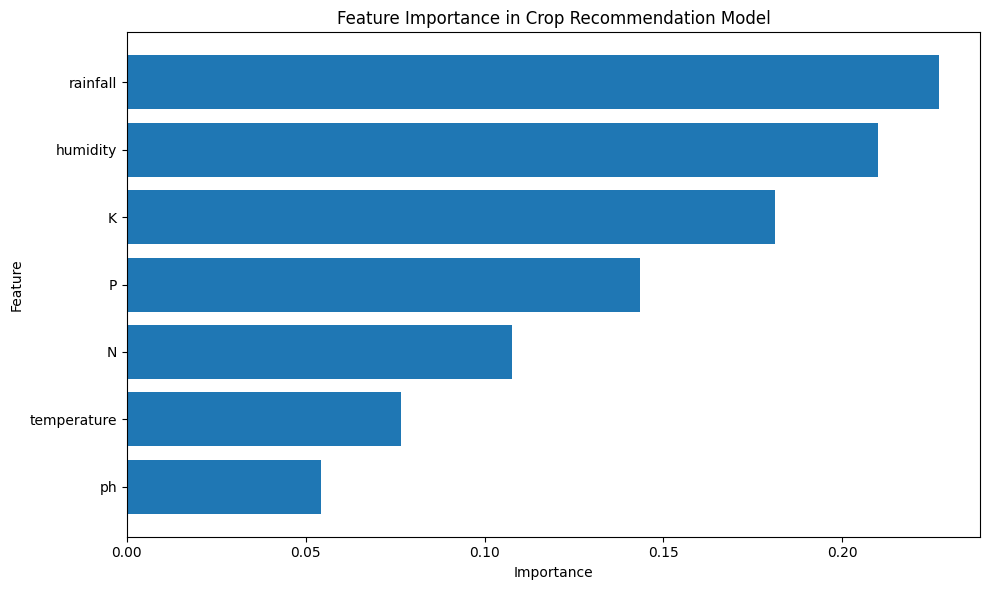

In [13]:
# Visualize feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Crop Recommendation Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Detailed Classification Report

In [14]:
# Print detailed classification report
print("Classification Report:")
print("=" * 80)
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
    

## 8. Test the Model with Sample Predictions

In [34]:
# Sample prediction (with soil type)
sample_input = pd.DataFrame({
    'N': [90],
    'P': [42],
    'K': [43],
    'temperature': [20.87],
    'humidity': [82.00],
    'ph': [6.50],
    'rainfall': [202.93],
    'soil_type_encoded': [le_soil.transform(['clay'])[0]]  # Example: clay soil
})

prediction = model.predict(sample_input)
prediction_proba = model.predict_proba(sample_input)

print("Sample Input:")
print(sample_input)
print(f"\nSoil Type: clay (encoded as {le_soil.transform(['clay'])[0]})")
print(f"\nPredicted Crop: {prediction[0]}")
print(f"Prediction Confidence: {max(prediction_proba[0]):.2%}")

Sample Input:
    N   P   K  temperature  humidity   ph  rainfall  soil_type_encoded
0  90  42  43        20.87      82.0  6.5    202.93                  0

Soil Type: clay (encoded as 0)

Predicted Crop: rice
Prediction Confidence: 100.00%


## 9. Train Additional Models for Comparison

Now let's train multiple models and compare their accuracy:

In [16]:
# Import additional models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import time

print("✅ Additional models imported successfully!")

✅ Additional models imported successfully!


### 9.1 Decision Tree Classifier

In [17]:
print("Training Decision Tree Classifier...")
start_time = time.time()

dt_model = DecisionTreeClassifier(random_state=42, max_depth=20)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_pred)

training_time = time.time() - start_time

print(f"✅ Decision Tree Accuracy: {dt_accuracy:.4f} ({dt_accuracy*100:.2f}%)")
print(f"⏱️  Training time: {training_time:.2f} seconds")

Training Decision Tree Classifier...
✅ Decision Tree Accuracy: 0.9864 (98.64%)
⏱️  Training time: 0.01 seconds


### 9.2 Logistic Regression

In [18]:
print("Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

training_time = time.time() - start_time

print(f"✅ Logistic Regression Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"⏱️  Training time: {training_time:.2f} seconds")

Training Logistic Regression...


/home/abdallah/Abdallah/Projects/Intelligent-Crop-Irrigation-Advisor-clone/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Logistic Regression Accuracy: 0.9545 (95.45%)
⏱️  Training time: 1.02 seconds


/home/abdallah/Abdallah/Projects/Intelligent-Crop-Irrigation-Advisor-clone/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 9.3 Support Vector Machine (SVM)

In [19]:
print("Training SVM Classifier...")
start_time = time.time()

svm_model = SVC(random_state=42, kernel='rbf')
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

training_time = time.time() - start_time

print(f"✅ SVM Accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"⏱️  Training time: {training_time:.2f} seconds")

Training SVM Classifier...
✅ SVM Accuracy: 0.9614 (96.14%)
⏱️  Training time: 0.07 seconds


### 9.4 Gradient Boosting Classifier

In [20]:
print("Training Gradient Boosting Classifier...")
start_time = time.time()

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

training_time = time.time() - start_time

print(f"✅ Gradient Boosting Accuracy: {gb_accuracy:.4f} ({gb_accuracy*100:.2f}%)")
print(f"⏱️  Training time: {training_time:.2f} seconds")

Training Gradient Boosting Classifier...
✅ Gradient Boosting Accuracy: 0.9818 (98.18%)
⏱️  Training time: 8.89 seconds


### 9.5 K-Nearest Neighbors (KNN)

In [21]:
print("Training K-Nearest Neighbors...")
start_time = time.time()

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

training_time = time.time() - start_time

print(f"✅ KNN Accuracy: {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%)")
print(f"⏱️  Training time: {training_time:.2f} seconds")

Training K-Nearest Neighbors...
✅ KNN Accuracy: 0.9705 (97.05%)
⏱️  Training time: 0.01 seconds


## 10. Models Comparison

Now let's compare all models based on their accuracy:

In [22]:
# Create comparison dataframe
comparison_data = {
    'Model': ['Random Forest', 'Decision Tree', 'Logistic Regression', 'SVM', 'Gradient Boosting', 'KNN'],
    'Accuracy': [accuracy, dt_accuracy, lr_accuracy, svm_accuracy, gb_accuracy, knn_accuracy]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
comparison_df['Accuracy %'] = comparison_df['Accuracy'] * 100

print("=" * 60)
print("MODEL COMPARISON - ACCURACY RESULTS")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("=" * 60)
print(f"\n🏆 Best Model: {comparison_df.iloc[0]['Model']}")
print(f"   Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f} ({comparison_df.iloc[0]['Accuracy %']:.2f}%)")

MODEL COMPARISON - ACCURACY RESULTS
              Model  Accuracy  Accuracy %
      Random Forest  0.993182   99.318182
      Decision Tree  0.986364   98.636364
  Gradient Boosting  0.981818   98.181818
                KNN  0.970455   97.045455
                SVM  0.961364   96.136364
Logistic Regression  0.954545   95.454545

🏆 Best Model: Random Forest
   Accuracy: 0.9932 (99.32%)


### 10.1 Visualize Model Comparison

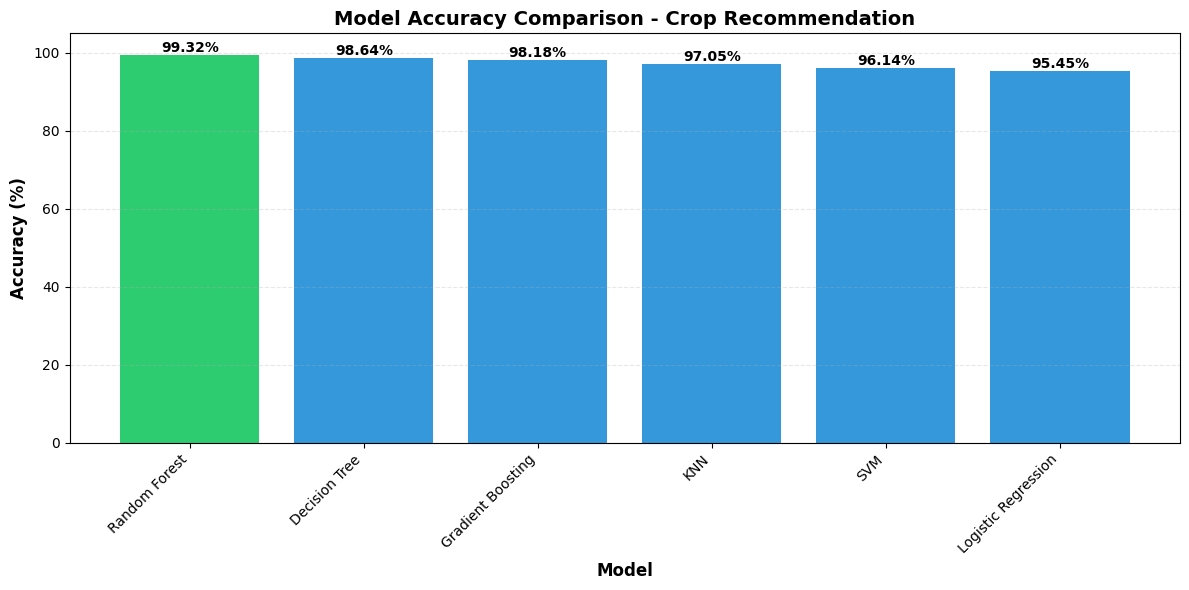

In [23]:
# Bar plot for model comparison
plt.figure(figsize=(12, 6))
colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(comparison_df))]
bars = plt.bar(comparison_df['Model'], comparison_df['Accuracy %'], color=colors)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontweight='bold')

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Accuracy Comparison - Crop Recommendation', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 105])
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

### 10.2 Detailed Metrics Comparison

In [24]:
# Calculate additional metrics for all models
models_dict = {
    'Random Forest': (model, y_pred),
    'Decision Tree': (dt_model, dt_pred),
    'Logistic Regression': (lr_model, lr_pred),
    'SVM': (svm_model, svm_pred),
    'Gradient Boosting': (gb_model, gb_pred),
    'KNN': (knn_model, knn_pred)
}

detailed_metrics = []
for model_name, (m, pred) in models_dict.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average='weighted')
    rec = recall_score(y_test, pred, average='weighted')
    f1_s = f1_score(y_test, pred, average='weighted')
    
    detailed_metrics.append({
        'Model': model_name,
        'Accuracy': f'{acc:.4f}',
        'Precision': f'{prec:.4f}',
        'Recall': f'{rec:.4f}',
        'F1-Score': f'{f1_s:.4f}'
    })

detailed_df = pd.DataFrame(detailed_metrics)
print("\n" + "=" * 80)
print("DETAILED METRICS COMPARISON")
print("=" * 80)
print(detailed_df.to_string(index=False))
print("=" * 80)


DETAILED METRICS COMPARISON
              Model Accuracy Precision Recall F1-Score
      Random Forest   0.9932    0.9937 0.9932   0.9932
      Decision Tree   0.9864    0.9868 0.9864   0.9863
Logistic Regression   0.9545    0.9562 0.9545   0.9547
                SVM   0.9614    0.9673 0.9614   0.9612
  Gradient Boosting   0.9818    0.9843 0.9818   0.9819
                KNN   0.9705    0.9740 0.9705   0.9703


### 10.3 Multi-Metric Visualization

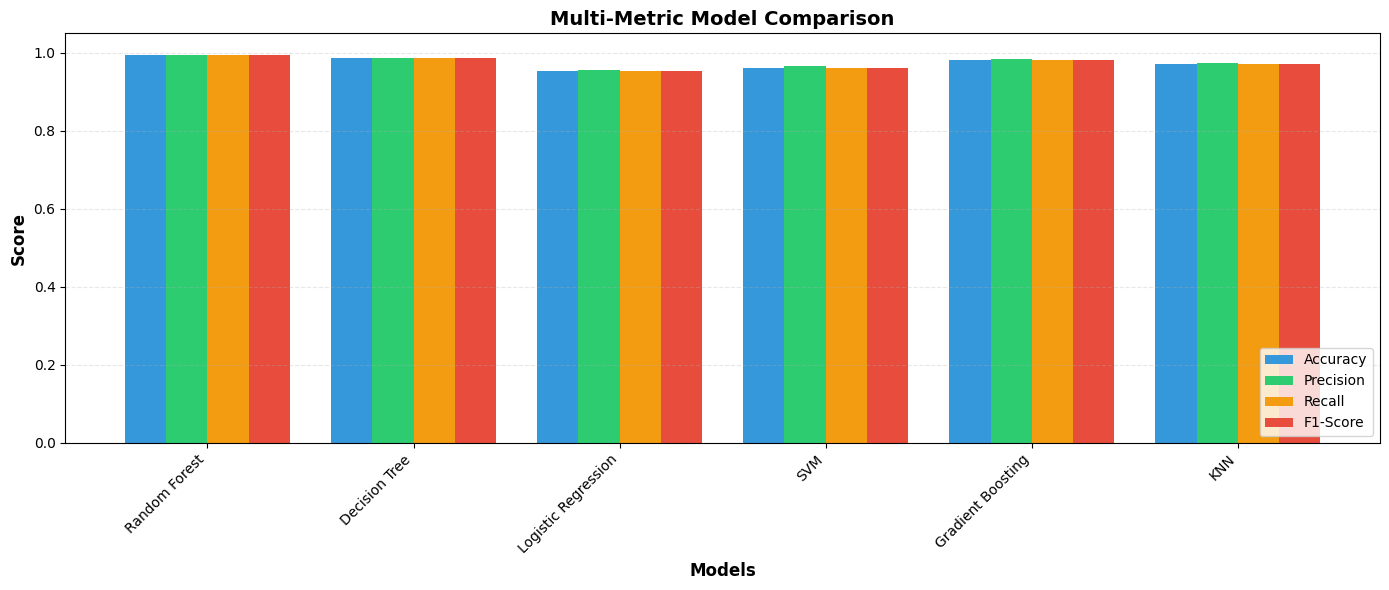

In [25]:
# Create grouped bar chart for all metrics
import numpy as np

metrics_for_plot = []
for model_name, (m, pred) in models_dict.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average='weighted')
    rec = recall_score(y_test, pred, average='weighted')
    f1_s = f1_score(y_test, pred, average='weighted')
    metrics_for_plot.append([acc, prec, rec, f1_s])

metrics_array = np.array(metrics_for_plot)
model_names = list(models_dict.keys())

# Create grouped bar chart
x = np.arange(len(model_names))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - 1.5*width, metrics_array[:, 0], width, label='Accuracy', color='#3498db')
ax.bar(x - 0.5*width, metrics_array[:, 1], width, label='Precision', color='#2ecc71')
ax.bar(x + 0.5*width, metrics_array[:, 2], width, label='Recall', color='#f39c12')
ax.bar(x + 1.5*width, metrics_array[:, 3], width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Multi-Metric Model Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## 11. Conclusion and Recommendations

Based on the model comparison:

In [26]:
# Summary and recommendations
best_model_name = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print("📊 MODEL EVALUATION SUMMARY")
print("=" * 80)
print(f"\n✅ Best Performing Model: {best_model_name}")
print(f"   • Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"\n📈 Model Rankings (by Accuracy):")
for idx, row in comparison_df.iterrows():
    rank = idx + 1
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"   {emoji} {rank}. {row['Model']}: {row['Accuracy %']:.2f}%")

print(f"\n💡 Recommendations:")
print(f"   • Use {best_model_name} for production deployment")
print(f"   • Consider ensemble methods combining top 3 models")
print(f"   • Monitor model performance on new data regularly")
print(f"   • Retrain models when accuracy drops below threshold")
print("=" * 80)

📊 MODEL EVALUATION SUMMARY

✅ Best Performing Model: Random Forest
   • Accuracy: 0.9932 (99.32%)

📈 Model Rankings (by Accuracy):
   🥇 1. Random Forest: 99.32%
   🥈 2. Decision Tree: 98.64%
      5. Gradient Boosting: 98.18%
      6. KNN: 97.05%
      4. SVM: 96.14%
   🥉 3. Logistic Regression: 95.45%

💡 Recommendations:
   • Use Random Forest for production deployment
   • Consider ensemble methods combining top 3 models
   • Monitor model performance on new data regularly
   • Retrain models when accuracy drops below threshold
